In [5]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

In [ ]:
pip install tabulate

In [ ]:
pip install Boruta

In [ ]:
pip install xgboost

In [1]:
## 0.1. Helper Functions

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) 
                          + ' +/- ' + np.round( np.std( mae_list ),                                                         
                                               2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) 
                          + ' +/- ' + np.round( np.std( mape_list ),
                                              2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) 
                          + ' +/- ' + np.round( np.std( rmse_list ),
                                            2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
# Questão de negócio: causa raiz do problema
# ex: dificuldade em determinar o valor do investimento em reformas de farmácia

# motivação: reunião de resultados
# quem é stackhlder: CFO
# formato da solução: predições acessadas via celular

In [ ]:
# Entendimento do negócio: 
# qual é a variável alvo ex: vendas
# tipo de problema ex: predição (classificação, regressão, previsão de demanda)
# granularidade ex: vendas diárias em R$ nas próximas 6 semanas
# método ex: predição, regressão, time series, redes neurais, LSTM


# Coleta de dados
        # requisição de APIs, banco de dados, webscaping e download
        # carregamento de dados

In [ ]:
## 0.2. Loading data

In [ ]:
df_sales_raw = pd.read_csv( 'C:/Users/paula/EndoCalc_Analytics/pasta/arquivo.csv', 
                           low_memory=False )
df_store_raw = pd.read_csv( 'C:/Users/paula/EndoCalc_Analytics/pasta/arquivo2.csv', 
                           low_memory=False )

In [ ]:
# se arquivo xlsx, converter para csv

read_file = pd.read_excel('C:/Users/paula/EndoCalc_Analytics/pasta/arquivo.xlsx')
read_file.to_csv('C:/Users/paula/EndoCalc_Analytics/vitaminad/copiaarquivo.xlsx')
df = read_file
df.head()

In [ ]:
# merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [ ]:
# verificar linha aleatoria

df_raw.sample()

# Limpeza de dados 
    # Quão desafiador é o problema? 
    # Estatística descritiva:
        # qde de dados (é necessário servidor, cluster, spark, hadoop?)
        # tipos de var: % num % cat % temporal
        # qde de dados faltantes (razão: sistema, input...)
    # Verificar datas, caracteres especiais, tipos de dados, etc    
    

# 1.0 DESCRICAO DOS DADOS

In [ ]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [ ]:
df_raw.columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 
            'StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
            'Promo2SinceYear', 'PromoInterval']

# alterar palavras p minusculo e separado por underscore

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename

df1.columns = cols_new

## 1.2. Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

## 1.3. Data Types

In [ ]:
df1.dtypes

In [ ]:
# alterar formato da data para datetime64

df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

In [ ]:
# alterar objeto para int64

df1['month'] = df1['month'].astype( 'int64' )

## 1.4. Check NA

In [ ]:
df1.isna().sum()

## 1.5. Fillout NA

In [ ]:
#  Como lidar com NA:

# 1 excluir: vantagem -> rápido ; desvantagem -> perda de informações que podem 
#ser relevantes
# 2 utilizar algoritmos de ML p substituir dados faltantes (clusterização) ou usar 
#mediana dependendo do caso
# 3 hipoteses deste negocio ex: se não existe dados do competidor mais proximo pode 
#ser pq ele está muito distante

In [ ]:
# verificar NA na coluna competition_distance

#classe.metodo(df['coluna'])

# math.isnan(df1['competition_distance'])

# para substituir os NAs da coluna competition_distance -> aplicar metodo p subst 
#pelo valor acima max

# df1('competition_distance').apply(lambda x: 200000 if math.isnan(x) else x)

In [ ]:
# verificar NA na coluna 'competition_open_since_month'

# hipoteses: pode ter sido aberto antes (registros) ou seja tem competidor mas não 
#foi registrado
    # pq foi aberto depois.
    # substituir o nan pela primeira data da venda
    
# quando o metodo utiliza mais de um coluna deve-se add axis=1

# df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
#else x['competition_open_since_month'], axis=1)

In [ ]:
# verificar month map transposto
# fiilina -> substituir por zero

#substituir numeros por letras  

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  
             8: 'Aug',  9: 'Sep',  10: 'Oct', 
             11: 'Nov', 12: 'Dec'}

#substituir por zero
# inplace=True -> aplicar diretamente

df1['promo_interval'].fillna(0, inplace=True )

# map -> mapear os dados dentro das colunas da coluna date

df1['month_map'] = df1['date'].dt.month.map( month_map )

In [ ]:
df1.sample(5).T

In [ ]:
df1.isna().sum()

## 1.6. Change Data Types

In [ ]:
df1['month'] = df1['month'].astype( 'int64' )

In [ ]:
# checar novamente após modificações

df1.dtypes

## 1.7. Descriptive Statistics

In [ ]:
# Ideia de negocio
# Objetivo: panorama sobre os dados do negócio e detectar erros
# Como: métricas de tendencia central
#       medidas de dispersão: 
#        concentração de dados : kurtosis (qto maior a kurtosis positiva maior o pico)
#        deformação em relação à normal: skew (esquerda deformação pos, 
# dir deformação neg)

In [ ]:
# separar em numerico e categorico

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [ ]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 
             kurtosis']
m

In [ ]:
# verificar distribuição de determinada variavel 

plt.figure(figsize=(25, 12)) 
sns.distplot( df1['competition_distance'], kde=False)

### 1.7.2. Categorical Atributes

In [ ]:
# verificar a quantidade de variaveis categoricas

cat_attributes.apply( lambda x: x.unique().shape[0] )

In [ ]:
# para comparar var diferentese e com linhas de determinada coluna com var != 0 & 
#coluna com var > 0

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

In [ ]:
# plotar grafico boxplot para comparar variaveis 

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#plt.subplot( num de linhas, num de colunas, posição do grafico  )

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

In [ ]:
# formatar dimesão dos graficos

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
sns.distplot( df1['competition_distance'], kde=False)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [ ]:
# Objetivo: Criar as variáveis disponíveis para estudo durante a Análise exploratória 
#de dados
# Como: derivando features de var originais e selecionando var disponíveis p o ciclo 
# visualização: através de mapa mental 

In [ ]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [ ]:
# Objetivo: enxergar o nível de detalhamento e quais variáveis para guiar na análise 
#explor de dados
# extremamente importante uma reunião com cada setor p verfic o impacto da VAR alvo

In [ ]:
# Como:

# 1- fenômeno: o que vc está tentando medir ou modelar p ensinar o algoritmo de ML 
#ex: vendas
# 2- agentes: entidades que impactam o fenômeno ex: produtos, clientes, lojas 
# 3- atributos dos agentes: caracteristicas do agente ex: idade do cliente, 
#frequencia compra 
# 4- lista de hipóteses: hipóteses para validar com os dados (surpresa e 
#contraposição da crença)

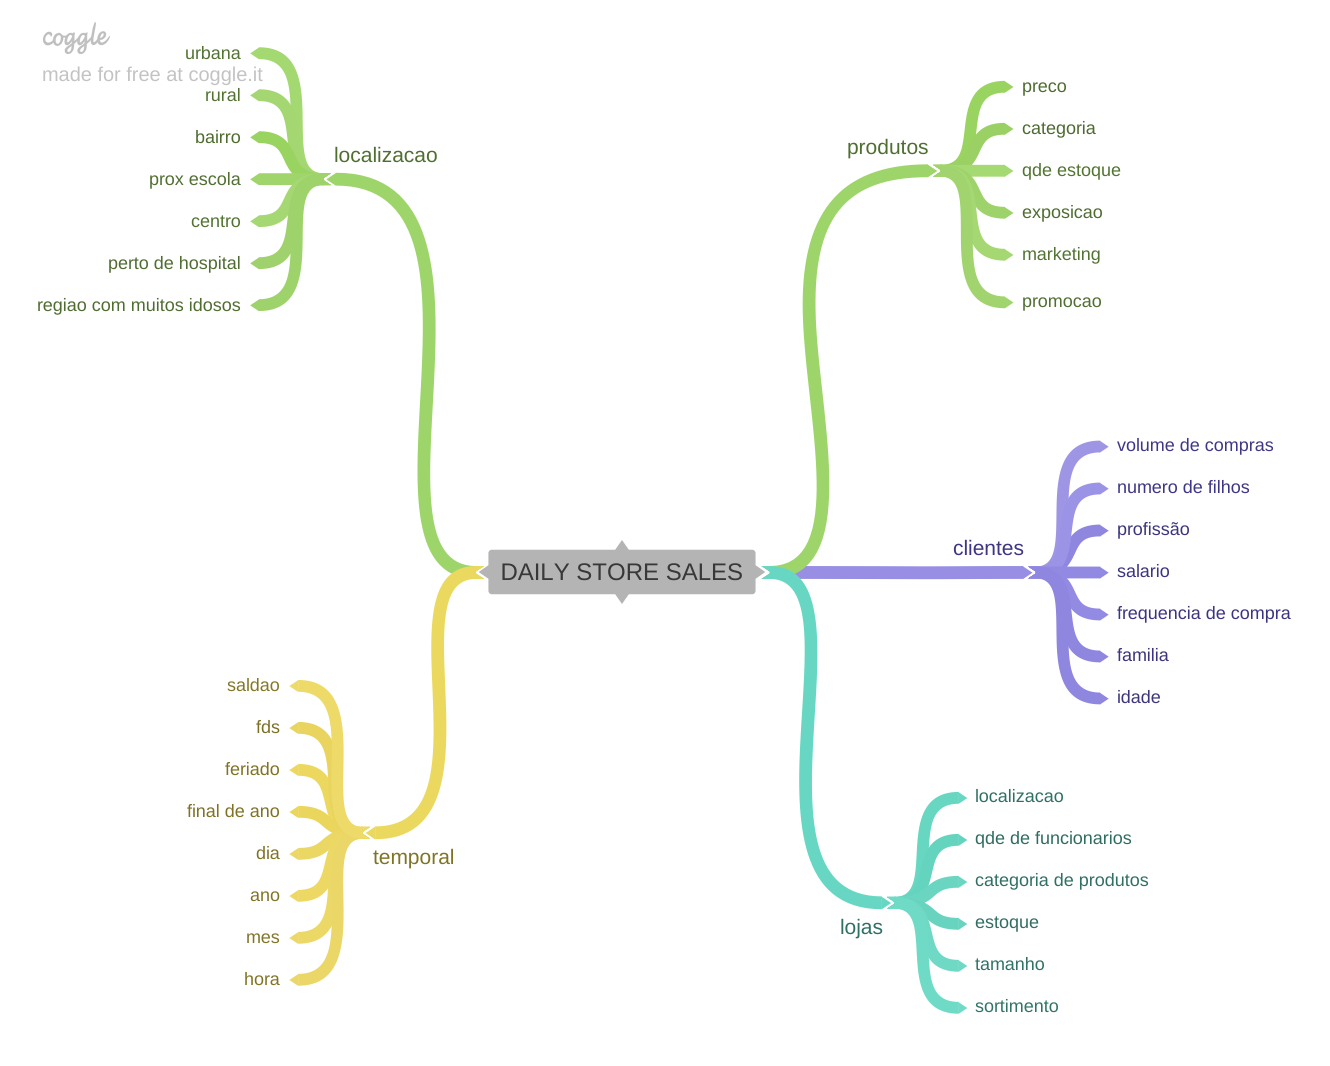

In [7]:
Image( 'C:/Users/paula/EndoCalc_Analytics/mindmap_sales.png' )

## 2.2. Criacao das Hipoteses

In [ ]:
# Agente 1 ex: loja

# Agente 2 ex: cliente

.
.
.
.

## 2.3. Lista Final de Hipóteses

In [ ]:
# Lista de hipóteses com informações disponíveis no momento

# Posteriormente -> # Verificar a correlação e a força entre as variáveis 
#(analise, bivar e multivar)

## 2.4. Feature Engineering

In [ ]:
# extrair ano de data

df2['year'] = df2['date'].dt.year

# extrair mês de data

df2['month'] = df2['date'].dt.month

# extrair dia de data

df2['day'] = df2['date'].dt.day

# extrair semana do ano de data

df2['week_of_year'] = df2['date'].dt.weekofyear

# # extrair semana e ano de data

df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since

df2['competition_since'] = df2.apply( lambda x: datetime.datetime
                                     ( year=x['competition_open_since_year'], 
                                      month=x['competition_open_since_month'],
                                      day=1 ), 
                                     axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).
                                   apply( lambda x: x.days ).astype( int )

# promo since desde quando a loja participa da promoção

df2['promo_since']=df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week']
.astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.
                                    strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta
                                              ( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days)
.astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply
( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply
( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
 else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [ ]:
# filtrar as linhas primeiro e depois as colunas -> performance

In [ ]:
# por que filtrar?
# para pensar nas restrições de negócio 
# pode ser variáveis que nao influenciam ou um problema específico como focar apenas nas 
#categorias 
# que mais impactam a VAR alvo

# quando? antes da análise exploratoria
# ex: df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# se a loja estiver fechada não existe razão para entrar na análise de vendas

# por que selecionar variáveis?
# verificar quais são relevantes para o modelo
# como: cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
#       df3 = df3.drop( cols_drop, axis=1 )

## 3.1. Filtragem das Linhas

In [ ]:
df3 = df2.copy()

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [ ]:
# dropar as colunas que não estarão disponíveis no momento da predição pq são restrições
#de negócio
# ex: customers -> não tem como prever o numero de clients na loja daqui x meses
# ex: open -> não diz muito sobre a previsão, há uma relação direta quando a loja está 
#fechada,ou seja somente qdo estiver aberta (0 e 1)
# sales > 0 tbem
# colunas que ja têm derivada para não comprometer a performance do modelo aumentando 
#o conjunto de dados

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [ ]:
df4 = df3.copy()

In [ ]:
# Objetivo: encontrar as variáveis que impactam a variavel resposta (alvo)/ negócio

# Como: através de gráficos (cada gráfico é ideal para um tipo espefícico de análise), 
    # levantamento de hipóteses, validação de hipoteses e geração de insights

# visualizar através de gráficos

# Histograma (distribuição de dados): ideal para numerico discreto ou continuo e 
#visualizar frequencia
    # informações relevantes: 
        # shape :sino, unimodal e bimodal
        # center : media e mediana
        # spread (qde de valores distintos na faixa): IQR, desvio padrão, variância 
        #e range
        
# Gráfico de frequencia (percentual): ideal para categórico nominal

# Boxplot : ideal para comparar muitas variaveis e correlacionar comportamento

# outlier -> 3x o desvio padrão ou 1,5I + Q3

# heatmap : correlação entre var (bivariada e multivar)

In [ ]:
## Analises univariada, bivariada e multivariada

# Análise univariada:
# como é essa variável? min, max, distribuição, range

# Análise bivariada:
# como é essa variável impacta na var resposta? correlação, validação de hipóteses, etc

# Análise multivariada:
# + de 1 VAR com a VAR resposta e como elas se relacionam?

In [ ]:
# os algoritmos de ML seguem algumas premissas e uma delas é a navalha de ockhan 
# ou seja essa teoria diz que se vc tiver vários modelos vc deve escolher o que tem a 
# menor complexidade pq ele generaliza o modelo melhor. 

# Uma das formas de tornar o dataset mais complexo é a dimensionalidade, ou seja, 
# varias colunas que 'dizem a mesma coisa' ou são derivadas das outras). 
# Se duas var são linearmente dependentes, vc poder retirar uma delas.

In [ ]:
# correlação entre VARs

# metodos para verificar a correlção entre var:
# qdo utilizar: antes de separar o conjunto de dados em treino e teste

# continua(var resposta) e continua: pearson
# continua(var resposta) e categorica: anova

# categorica(var resposta) e continua: LDA
# categorica(var resposta) e categorica: CHI-square/ cramer's V

In [ ]:
# correlação entre VAR NUMERICAS :
    # se linear -> correlação de pearson (razão, linear)
    correlation = num_attributes.corr( method='pearson' )
    sns.heatmap( correlation, annot=True );
    
    # se nunca diminui ou aumenta -> sperman (mais complexo, equ 2 grau etc)
    
# correlação entre variavel num e cat
    # cramer
    a = df4.select_dtypes( include='object' )
    # Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [ ]:
# Tipos de seleção de varia´veis (classificar relevante / não relevante):
# qdo utilizar: antes de separar o conjunto de dados em treino e teste

# Seleção univariada(Filter methods): 
# Seleção por importância (embedded methods)
# Seleção por subset (wropper methods)

## 4.1. Analise Univariada

### 4.1.1. Response Variable

In [ ]:
# plotar a distribuição

# objetivo: pq alguns algoritmos de ML são criados baseados em algumas premissas:
# dados independentes e uma distruição normal

sns.distplot( df4['sales'], kde=False  )

### 4.1.2. Numerical Variable

In [ ]:
num_attributes.hist( bins=25 );

# bin = numero de caixas 5x5

In [ ]:
# VERIFICAR A DISTRIBUIÇÃO DE CADA GRAFICO:
      # uniforme: não explica muita coisa
      # distribuição bimodal : interesante p explicar o modelo
      # normal
      # deslocada p esquerda (concentração no inicio)

### 4.1.3. Categorical Variable

In [ ]:
# state_holiday

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], 
            label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], 
            label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], 
            label='christmas', shade=True )

# store_type

plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], 
            label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Analise Bivariada

In [ ]:
# verificar as hipóteses

In [ ]:
# grafico de barras para correlacionar variaveis com VAR resposta

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# grafico linha do tempo e comparativo de 2 var com VAR resposta

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'])
.sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# grafico linha do tempo e comparativo de 1 var com VAR resposta

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

In [ ]:
# DISTRIBUIÇÃO, GRUPOS E CORRELAÇÃO

In [ ]:
# grafico de frequencia para correlacionar variaveL com VAR resposta

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' )
.sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

# grafico de barras para correlacionar variaveis com VAR resposta

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], 
                                             bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].
groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# grafico de CALOR para correlacionar variaveL com VAR resposta
# observando o grafico competition_distance x sales parece existir uma relação direta, 
#por isso aplica-se pearson (0 correl fraca e 1 ou -1 corr forte)

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [ ]:
# Comparar var de acordo com tipo e tipo por ano

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] )
.sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

In [ ]:
# verificar cat com VAR resposta em determinado periodo
# ex:verificar a categoria de produtos mais vendidos nas ferias

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] )
.sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipoteses

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - DATA PREPARATION

In [ ]:
df5 = df4.copy()

In [ ]:
# Os ALG de ML foram criados com alguns critérios sendo a maioria:
# distribuição NORMAL, na mesma ESCALA, GRANDEZA e natureza real.
# para isso foram criados métodos de otimização que utilizam os melhores parametros 
#p dataset

# distribuição NORMAL -> usada apenas nos graficos com distribuição normal da 
#analise exploratoria
# COMO -> # rescala o centro p 0 com desvio padrao igual a 1 (-1 a 1)

# distribuição não gaussiana -> usada apenas nos graficos com distribuição NÃO normal 
# como -> rescala p intervalo entre 0 e 1 
# onde encontrar: na análise univariada

# tecnicas de rescaling:
# min-max-scaler (formula para coluna e fazer nova escala)
# robust scaler: diferença p cada quartil (interquartil ou seja minimiza o problema 
#com outiers)

In [ ]:
# selecionar VARs com distribuição normal, não gaussiana, cat e natureza ciclica

# Normalização -> reescalar p distribuição normal (range)

# Rescaling -> reescalar p distribuição não gaussiana (range)
    # existe outliers? ->  sns.boxplot(df['nomedacoluna'])
        # var1: SIM -> usar robust scaler : rs = RobustScaler()
        # var2:  Não -> minmaxscaler

# Transformação -> grandeza e natureza
    # grandeza: cat para num (verificar a performance do modelo com cada tipo )
        # One hot: indicado mudança de comportam,ideal p poucas variações pois > o 
    #dataset com colunas
        # Label encoding : indicado p quando nao existe uma ordem, nomes
        # Ordinal encoding: indicado para ordens
        # Target encoding: indicado para numero gde de var categoricas. ex: cores
        # Frequency encoding: indicado para numero gde de var categoricas p indicar freq
        # Embedding encoding: indicada p NLP. ex: previsão de demanda, LSTM
        
    # natureza: transforma a distribuição da var resposta mais próxima de uma 
    #distrib normal
        # Logarithm
        # Box-cox
        # Cube-root
        # Square-root
        # Sine cosine

## 5.1. Normalizacao

## 5.2. Rescaling

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
# fit encontra os parâmetros e aplica a formula

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

In [ ]:
# verificar range apos rescaling - > sns.distplot(df['nomedacoluna']) 
# 0 a 1 eixo y

## 5.3. Transformacao

### 5.3.1. Encoding

In [ ]:
# Grandeza: os algor de ML foram construidos com algumas premissas e qto mais próximo dessas
# premissas (distribuição normal) maior será a acurácia

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [ ]:
#Tipos de transformação:

# 1 Logarithm transformation: transforma a distribuição da var resposta mais prox 
#distribuição normal 
# 2 Box-cox transformation: 
# 3 Cube-root transformation: 
# 4 Square-root transformation: 
# 5 Sine and cosine transformation: cíclica ex: meses

In [ ]:
# transformar a distribuição da var resposta -> log

df5['sales'] = np.log1p( df5['sales'] )

In [ ]:
# visualizar
#sns.distplot(df['nomedacoluna'])

### 5.3.3. Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply
( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply
( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin
                                                    ( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos
                                                    ( x * ( 2. * np.pi/52 ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

In [ ]:
# Selecionar as VARs mais importantes para o negócio
# relevância: qual var explica melhor o fenômeno ou maior parte do fenômeno

# Como -> método de seleção de VARs (relevância):

    # univariada -> através da correlação FORTE -1 e 1 e FRACA 0 | VAR que 
    #mais explica o fenômeno
    # como:
        # pearson : num (var resposta) num
        # anova : num cat
        # LDA : cat num
        # Q2/cramer : cat cat 
    # vantegem: simples e facil entendimento
    # desvantegem: não considera influencia entre VARs (pode eliminar uma VAR 
    #q combinada é forte)
    
    
    # importância -> é um subproduto do proprio aprendizado de alguns algoritmos
    # como:
        # random forest: seleciona as melhores VARs p treinar o modelo ou seja,
        # as arvores separam sempre a var em 2 grupos homogenios, seleciona uma 
        #VAR e compara
        # encontrando as var mais importantes. (método da impureza Gini Impurity)
        # Lasso regressão
        # Ridge regressão -> esses fornecem um peso p cada VAR (algoritmos de 
        #regressão regularizados
        # usam algumas artimanhas math para que seus pesos fiquem em uma range)
        # seleciona um conj que explica gde parte do fenômeno
        
        
    # subset -> BORUTA seleciona uma VAR aleatória, treina um modelo (RF, XGBOOST)
    #, calc a performance 
    # do modelo, se aum performance mantem, senão remove. 
    # algoritmo Boruta (cria novas colunas copias com a segunda coluna com 
    #numeros embaralhados- shadow features)


In [ ]:
# Navalha de ockham: dê preferência para modelos mais simples (colunas)

# Remover variaveis colineares/deletar as colunas que originaram outras no 
#feature engineering



In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 
             'competition_since']
df6 = df6.drop( cols_drop, axis=1 )

In [ ]:
# ATENÇÃO à VAR em relação ao tempo
# ex: vendas em relação ao tempo: separar as ultimas 6 semanas p teste

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - 
datetime.timedelta(days=6*7)

## 6.1. Split dataframe into training and test dataset

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

## 6.2. Boruta as Feature Selector

In [ ]:
## training and test dataset for Boruta

#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).
#fit( X_train_n, y_train_n )

In [ ]:
# Como o Boruta é um algoritmo de selação de VAR por relevância (método seleção subset),
# antes de treinar o Boruta p selecionar VARs devemos dropar as VARs treino do negócio,
# ou seja 'date' e 'sales'
# X_train_n e y_train_n -> não aplica no dataframe e sim no vetor de numeros (numpy)
# axis=1 -> aplicar em todas as colunas ao longo das linhas
# values -> apenas numpy e não dataframe
# ravel -> colocar dentro do vetor
# n_jobs -> criar todos os core em paralelo
# rf -> modelo usado para seleção de features
# 'auto' -> o próprio algoritmo escolhe o n de arvores
# verbose -> printar as linhas
# random_state -> partir da mesma linha de árvores. n=42 é aleatorio


In [ ]:
# Funcionamento do Boruta:

# Funciona usando o conceito de subset:
# Seleciona 2 VARs aleatórias do dataset original
# Cria 2 colunas idênticas porem com linhas embaralhadas (p não criar correlação 
#entre elas)
# Novo conj com 4 VARs
# Treina o modelo (randon forest ou XGBoost)
# Verica as VARs shadom + importantes
# Fixa a VAR mais importante da shadom e compara a importancia com as VARs originais
    # se a VAR original > VAR selecionada -> 1, senão 0
# Após a construção da tabela com 0 e 1 tem-se Sucess counts
# Aplica distribuição binomial
# Encontra o p-value (aceita ou rejeita a VAR)
    # se p-value da VAR < p-limite -> confirma , senão rejeita 
# Reduced dataset    
    

### 6.2.1. Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [ ]:
# support -> valor do ranking a coluna VAR baseado na relevancia
# tolist -> colococar na lista
# setdiff1d -> o que tem na 'columns' que não tem na 'cols_selected_boruta'

## 6.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [ ]:
# extend -> inserir elemento da lista de elementos'feat_to_add' 

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [ ]:
# objetivo do ML: aprender o comportamento (neste caso VENDAS) com as var disponiveis 
# para generaliza-las no futuro.

In [ ]:
# Supervisionado

# regressão: var resposta numeros ex: previsao de vendas, valor de venda, dimensao
# classificação: var resposta classe (numero ou nomes), deep learning
# series temporais: previsao: numero ao longo do tempo

In [ ]:
# Não supervisionado

# agrupamento / clusterização

In [ ]:
# Semi-supervisionado

# reiforcement learning

# Aprende durante a execução (ação e recompensa)
# agente(codigo) e ambiente: o agente faz uma ação e recebe uma recompensa + ou -

In [ ]:
# sem 'date' e 'sales'

x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [ ]:
# Como escolher o modelo

# Modelo de média -> objetivo é comparar com os modelos que serão aplicados
# se a performance do modelo > performance media  OK, senão mantem modelo media

# Regressão linear 

# Regressão linear regularizado (lasso e ridge) -> o objetivo é verificar a 
#complexidade do modelo
# se a performance for ruim significa que o modelo é mais complexo

# Random forest regressor e XGBoost -> modelos de classificação adaptados p regressão
# o XGBoost consegue selecionar as features mais rapidamente

## 7.1. Average Model

In [ ]:
# modelo de media: prever a media (serve como baseline ou seja para comparar com 
#modelo de ML, 
# se maior ou menor)
# RMSE menor que lasso e regressão -> o modelo é mais complexo

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename
                                           ( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

In [ ]:
# aux1 -> base do conj de dados
# aux2 -> prediction
# on='store' -> coluna chave
# expm1 -> as vendas foram usadas com log, logo reverter p modelo np

## 7.2. Linear Regression Model

In [ ]:
# baseado no Ockhan navalha começamos por modelos simples, como os lineares. 
# se a performance não for boa é pq o modelo significa q o modelo é mais complexo

In [ ]:
# Modelos baseados em arvores (classificação)

# Random forest
# XGBoost regressor

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

In [ ]:
# predict -> método da classe LinearRegression
# x_test -> dados de teste
# y_teste -> dados reais
# yhat_lr -> predições
# expm1 -> voltar p dados originais


# y_train -> VAR resposta do treino

# se O erro RMSE do RL > media -> o modelo media é melhor e os dados têm comportamento 
#+complexo
# sendo assim, os modelos lineares não são indicados

### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), 
                      np.expm1( yhat_lrr ) )
lrr_result

In [ ]:
# alpha -> ficar dentro do range (reduzir o alpha pode melhorar a performance)

In [ ]:
# se O erro RMSE do Lasso > RL-> o modelo é +complexo
# sendo assim, os modelos lineares não são indicados, indicado modelos + complexos 
#não lineares

### 7.3.1.  Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

## 7.4. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, 
                                                                               y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

In [ ]:
# n_estimators -> numero de arvores (se 1000 melhor rodar em servidor)
# n_jobs -> rodar em paralelo
# random_state -> partir da mesma origem (num aleatorio)

### 7.4.1.  Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5,'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

In [ ]:
# xgb.XGBRegressor -> classe.metodo
# objective -> função objetiva
# eta -> qtas passadas p aprendizado
# max_depth -> profundidade da arvore (ramificação max)
# subsample -> % da amostra p selecionar  + relevantes
# colsample_bytee -> p varias árvores

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5,'XGBoost Regressor',model_xgb,verbose=True)
xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, 
                               xgb_result] )
modelling_result.sort_values( 'RMSE' )

In [ ]:
Model Name	MAE	MAPE	RMSE
0	Random Forest Regressor	679.622763	0.099960	1011.191561
0	XGBoost Regressor	843.112292	0.122609	1250.952634
0	Average Model	1354.800353	0.455051	1835.135542
0	Linear Regression	1867.089774	0.292694	2671.049215
0	Linear Regression - Lasso	1891.704881	0.289106	2744.451737

In [ ]:
# conclusões: 
# RF (RMSE menor)  -> o problema é mais complexo  e não pode ser linaer

In [ ]:
# não representa a performance real pois foi avaliado somente um período e assim pode correr 
# o risco de não representar o totalmente os dados pois pode selecionar momentos atipicos
# para isso existe o cross validation, ou seja, selecionar varios periodos de tempo
# para representar a variabilidade do conjunto de daodos

### 7.6.2. Real Performance - Cross Validation

In [ ]:
# cross validation -> dividir o conjunto de dados em varias partes
# para medir a performance do modelo sobre cada uma dessas partes

# tecnica usada em regressão ou classificação, time series tbem com uma pna modificação

# metodo cross validation times series -> deve respeitar ordem cronologica (periodo). 
# separar em treino e validação e validação é sempre do mesmo tamanho,
# para todas iterações treino e teste

In [ ]:
# verificar no item 6 

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend(feat_to_add)

# x_training = X_train[cols_selected_boruta_full] -> (p selecionar as colunas date e sales)

In [ ]:
# start and end date for validation

# validation_start_date = x_training['date'].max() - 
#datetime.timedelta(days=1*6*7)
# validation_end_date = x_training['date'].max() - 
#datetime.timedelta(days=0*6*7)

# filtering dataset

# training = x_training[x_training['date'] < validation_start_date]
# validation = x_training[(x_training['date'] >= validation_start_date) 
#& (x_training['date'] <= validation_end_date)]

In [ ]:

mae_list = []
mape_list = []
rmse_list = []


k = 1
for k in reversed(range(1, kfold+1)):
    print('\nKFold Number: {}'.format(k))

    # start and end date for validation

    validation_start_date = x_training['date'].max() - datetime.timedelta(days=1*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=0*6*7)

    # filtering dataset

    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & 
                            (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    # training
    xtraining = training.drop(['date', 'sale'], axis=1)
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop(['date', 'sale'], axis=1)
    yvalidation = validation['sales']

    # model
    lr = LinearRegression().fit(xtraining, ytraining)

    # prediction
    yhat_lr = lr.predict(xvalidation)

    # performance
    lr_result = ml_error('Linear Regression', np.expml(yvalidation), np.expml(yhat_lr))
    
    # store performance of each kfold iteration
    mae_list.append(lr_result['MAE'])
    mape_list.append(lr_result['MAPE'])
    rmse_list.append(lr_result['RMSE'])
    
    pd.DataFrame({'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' 
+ np.round(np.std(mae_list),2).astype(str),
     'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' 
+ np.round(np.std(mape_list),2).astype(str),
      'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' 
+ np.round(np.std(rmse_list),2).astype(str)}, index=[0])
    

In [ ]:
#testar o dicionario MAE CV

np.round(np.mean(mae_list),2).astype(str) + ' +/- ' 
+ np.round(np.mean(mae_list),2).astype(str)


In [ ]:
x_training = X_train[cols_selected_boruta_full]

In [ ]:
a = cross_validation(x_training, 5)

In [ ]:
a

In [ ]:
# performance real da regressão linear -> MAE, rmse

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, 
                                  xgb_result_cv] )
modelling_result_cv

In [ ]:
# a validação cruzada corta a amostra em várias partes aleatorias
# p verificar o modelo e é ideal apresenta a margem erro p cada um

In [ ]:
Model Name	MAE CV	MAPE CV	RMSE CV
0	Linear Regression	2081.73 +/- 295.63	0.3 +/- 0.02	2952.52 +/- 468.37
0	Lasso	2116.38 +/- 341.5	0.29 +/- 0.01	3057.75 +/- 504.26
0	Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36    -> MELHOR PERFORMANCE
0	XGBoost Regressor	1030.28 +/- 167.19	0.14 +/- 0.02	1478.26 +/- 229.79   -TAMANHO DO MODELO É MENOR(ECONOMIA)

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

In [ ]:
# AJUSTE FINO DOS HIPERPARAMETROS
    # hiperparametros - > todos os parametros q o modelo usa para aprender
    # um comportamento ex: 
    # RN -> NUM NEURONIOS, NUM CAMADAS, FUNÇÃO ATIVAÇÃO, ITA
    # RF -> num de estimadores, max profundidade das arvores, num nos, ita
    
    # objetivo: encontrar um conj de patametros que maximiza
    # o aprendizado do modelo

In [ ]:
# Estratégias de fine tuning:

# Random search: rápido e baixo custo. desvantagem: define valores para cada um dos 
# hiperparametros aleatoriamente

# Grid search: define os verdadeiros valores que maximizam o aprendizado do modelo. 
# define todas as combinações possiveis de valores q hiperpar podem assumir
# desvantagem: demorado e alto custo


# Bayesian search: define valores baseado em aprendizados passados. 
# define valores p hiperpar seguindo teoria  de Bayes
# desvantagem: mais rapido que grid e mais lento que random.

In [ ]:
# Hiperparametros são os parâmetros utilizados pelos algoritmos de machine learning 
# para a aplicação no dataset
# Fine Tuning é ajuste final do algoritmo. dependendo da aplicação esse ajuste pode 
# ser extremamente importante.

# Estratégias de fine tuning:

# Random search: rápido e baixo custo. desvantagem: define valores aleatoriamente 
# e pode nunca encontrar os valores melhores 
# Grid search: define os verdadeiros valores que maximizam o aprendizado do modelo. 
# desvantagem: demorado e alto custo
# Bayesian search: define valores baseado em aprendizados passados(tentativa anterior). 
# desvantagem: mais rapido que grid e mais lento que random.

## 8.1. Random Search

In [ ]:
# pode ser usado em qq modelo e é mais rapido.

In [ ]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],     -> qto maior mais combinações
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation(x_training, 5,'XGBoost Regressor',model_xgb,verbose=True)
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

## 8.2. Final Model

In [ ]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).
fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), 
                            np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

In [ ]:
# SALVAR MODELO TREINADO (fazer tbem p boruta)

import pickle

pickle.dump(model_xgb_tuned, open('C:/Users/paula/EndoCalc_Analytics/pasta/modelo.pkl', 'wb'))

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [ ]:
# 1-PERFORMANCE DO MODELO DE REGRESSÃO:

# MAE(mean absolute error): erro medio abs atribui o mesmo peso p todos os erros, facil 
#entendimento, robusto na presenças de outliers (pode ser ruim)

# MAPE(mean absolute percentage error): mostra o quao longe a predição esta longe do valor 
#real, na media e em porcentagem. muito 
#usado na divulgação de resultados. não pode ser usado quando a var resposta contem 0.

# RMSE(root mean squared error): atribui maior peso a erros maiores. sensivel na presença 
# de outliers. ideal para medir a performance de modelos de ML

# MPE(mean percented error): não pode ser usado para medir performance do modelo. 
# útil para entender se o modelo está subestimado(valor negativo) superestimado(valor positivo). 
# não pode ser usado se a var resposta contem 0.


# 2-PERFORMANCE DO MODELO SOBRE O NEGOCIO:

# comparação com o status quo (como é atualmente)

# incremento de receita (problema de faturamento)

In [ ]:
np.expm1(y_test).min()

In [ ]:
569

In [ ]:
np.expm1(y_test).max()

In [ ]:
41550

In [ ]:
np.expm1(y_test).max() - np.expm1(y_test).min()

In [ ]:
40981

In [ ]:
MAE: 665
MAPE: 0.097 (10%)
RMSE: 958    

In [ ]:
erro MAE 665/40981 = 1.5 %

In [ ]:
np.expm1(y_test).mean()

In [ ]:
6995

In [ ]:
erro MAPE 665/6995 = 10 %

In [ ]:
erro de predição de vendas -> 10%

In [ ]:
RMSE

In [ ]:
956/6695 = erro 14%

In [ ]:
# 1-PERFORMANCE DO MODELO DE REGRESSÃO: 
# metricas para melhoria de perfornace do modelo-> RMSE e MPE

# 2-PERFORMANCE DO MODELO SOBRE O NEGOCIO: 
# MAE, MAPE, MPE-> metricas de report para time de negocios

# bastante rigor na resposta do projeto rmse

In [ ]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

In [ ]:
-0.003 (valor predito maior que real)

In [ ]:
MELHORIA: ERRO ATUAL  - ERRO DO MODELO
    MAE E MAPE

## 9.0. Tradução e interpretação do erro

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply
( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().
rename( columns={0:'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply
( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).
reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sample(4)

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: 
np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
c